# Training VGG16 to Classify Rock Paper Scissors Images

In this notebook we will be training a `keras.applications.VGG16` Convolutional Neural Network (CNN) on the Rock Paper Scissors (RPS) images preprocessed in `image_processing.ipynb` and organized into train and test sets with `combined_test.sh`. 

VGG16 model performance on the existing images will then be evaluated using `sklearn.metrics.classification_report` and `confusion_matrix`. 

Model performance on real-time images will similarly be evaluated in notebook: `real-time_test.ipynb`. 

In [1]:
# Importing the usual libraries 
import pandas as pd
import numpy as np

# importing layers
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, model_from_json, Sequential
from keras.optimizers import Adam
from keras.utils import plot_model

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaboarn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


VGG16 was selected based on a previous [project](https://github.com/angelphanth/alphabet_asl) I had completed where VGG16 CNN had superior performance when classifying letters of the Americal Sign Language alphabet from webcam images taken in real-time when compared to VGG19, Xception and InceptionResNetV2.

Transfer learning was configured using the following Medium articles written by [Parkash Jay](https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8) and [James Le](https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d). 

The model will undergo a minimum of 12 and a maximum of 30 phases of learning (epochs) to minimize the amount of error (or `categorical_crossentropy`) when classifying the validation (10% of training set) RPS images. 

In [2]:
# Saving variables that will be called upon throughout the notebook 
classes = 3 
pixels = 300
channels = 3 #if 3 'color_mode="rgb"', if 1 'color_mode="grayscale"'
path = ''
batch_size = 20

# Training the model for a minimum of 12 and maximum of 30 epochs
min_epochs=12
epochs=30

# Initialize the model 
model = Sequential() 

In [3]:
# Import the pretrained VGG16 network, do not include the top layers
# Import the architecture with the weights by ='imagenet'
pretrained = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(pixels,pixels,channels))

# Setting the first few layers to not trainable so weights wont be tweaked
for layer in pretrained.layers[:4]:
    layer.trainable=False
# Allow all other layers to be trained on the RPS images    
for layer in pretrained.layers[4:]:
    layer.trainable=True
    
# Display VGG16 architecture
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [4]:
# Adding VGG16 to the model
model.add(pretrained)

# Adding additional dense layers
model.add(Dense(256))
model.add(Dense(512))
model.add(Dense(classes, activation='softmax'))
    
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 14,979,139
Trainable params: 14,940,419
Non-trainable params: 38,720
_________________________________________________________________


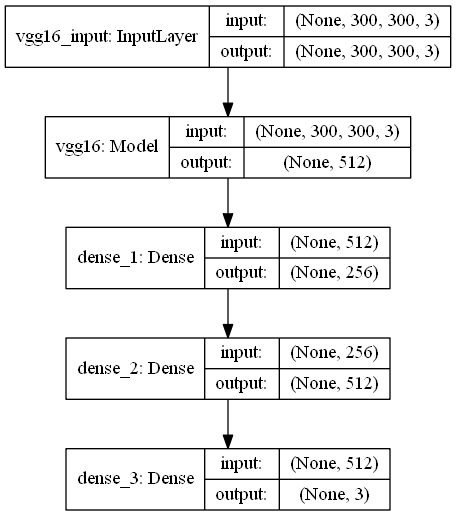

In [5]:
# Saving the model summary as an image
plot_model(model, to_file='rps_full.png', 
show_shapes=True, show_layer_names=True)                          

Image augmentation was configured using the following [resource](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/). 

Images were augmented in the hopes of improving the VGG16 model's ability to classify new RPS images (e.g., real-time webcam images). 

In [6]:
# Istantiating the training/validation ImageDataGenerator()
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=90,
                                   width_shift_range=[-15,15],
                                   height_shift_range=[-15,15],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   fill_mode='reflect',
                                   validation_split=0.1)

# Istantiating the test generator
datagen_test = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  rotation_range=90,
                                  width_shift_range=[-15,15],
                                  height_shift_range=[-15,15],
                                  zoom_range=0.1,
                                  shear_range=0.2,
                                  fill_mode='reflect')

In [9]:
# The generator for the training data, shuffle set to True 
# (unable to view confusion matrix and classification report as a result)
train_generator = datagen_train.flow_from_directory(path+'training_set/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='training')

# Generator for validation data, shuffle set to 'False' to allow for model evaluation
validation_generator = datagen_train.flow_from_directory(path+'training_set/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False, subset='validation')

# Generator for test data, shuffle set to 'False' to allow for model evaluation
test_generator = datagen_test.flow_from_directory(path+'test_set/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 3844 images belonging to 3 classes.
Found 427 images belonging to 3 classes.
Found 809 images belonging to 3 classes.


In [10]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.n//train_generator.batch_size + 1
valid_stepsize = validation_generator.samples//validation_generator.batch_size + 1
test_stepsize = test_generator.samples//test_generator.batch_size + 1

# Sanity check 
print(f'Training step size = {train_stepsize}, Validation step size = {valid_stepsize}')
print(f'Test step size = {test_stepsize}')

Training step size = 193, Validation step size = 22
Test step size = 41


Finally, we will utilize `keras.callbacks`: 

- `EarlyStopping()` to [prevent overfitting](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) to the training images, and 


- `ModelCheckpoint()` to [save the best model weights](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) which may not coincide with the model at the end of training.  



In [11]:
# Early stopping will help prevent overfitting the model to the train data, 
# Initiate early stop based on validation accuracy
# Will not stop before 'min_epochs' of 12 (patience)
ES = EarlyStopping(monitor='val_accuracy', mode='auto', min_delta=0, patience=min_epochs, verbose=1)

# Model checkpointer that will only save the weights from the epoch with the best validation accuracy
checkpoint = ModelCheckpoint("best_weights_vgg16.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# Adding both callbacks to a 'callbacks_list'
callbacks_list = [ES, checkpoint]    

Now, we will compile and train the model on the training RPS images. 

The model's progress will be saved to the variable `history` to allow for visualization of the progression of train and validation accuracies and losses.  

In [12]:
# Fitting the model to the training data
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=callbacks_list)

Epoch 1/30
193/193 [==============================] - 115s 596ms/step - loss: 0.6034 - accuracy: 0.7019 - val_loss: 0.0086 - val_accuracy: 0.9625

Epoch 00001: val_accuracy improved from -inf to 0.96253, saving model to best_weights_vgg16.h5
Epoch 2/30
193/193 [==============================] - 103s 536ms/step - loss: 0.1123 - accuracy: 0.9625 - val_loss: 0.1002 - val_accuracy: 0.9578

Epoch 00002: val_accuracy did not improve from 0.96253
Epoch 3/30
193/193 [==============================] - 104s 537ms/step - loss: 0.0592 - accuracy: 0.9820 - val_loss: 0.0067 - val_accuracy: 0.9625

Epoch 00003: val_accuracy did not improve from 0.96253
Epoch 4/30
193/193 [==============================] - 104s 541ms/step - loss: 0.0377 - accuracy: 0.9886 - val_loss: 2.8890e-04 - val_accuracy: 0.9742

Epoch 00004: val_accuracy improved from 0.96253 to 0.97424, saving model to best_weights_vgg16.h5
Epoch 5/30
193/193 [==============================] - 105s 544ms/step - loss: 0.0424 - accuracy: 0.9867 -

Visualizing the model's training and validation loss and accuracy progression for every epoch. 

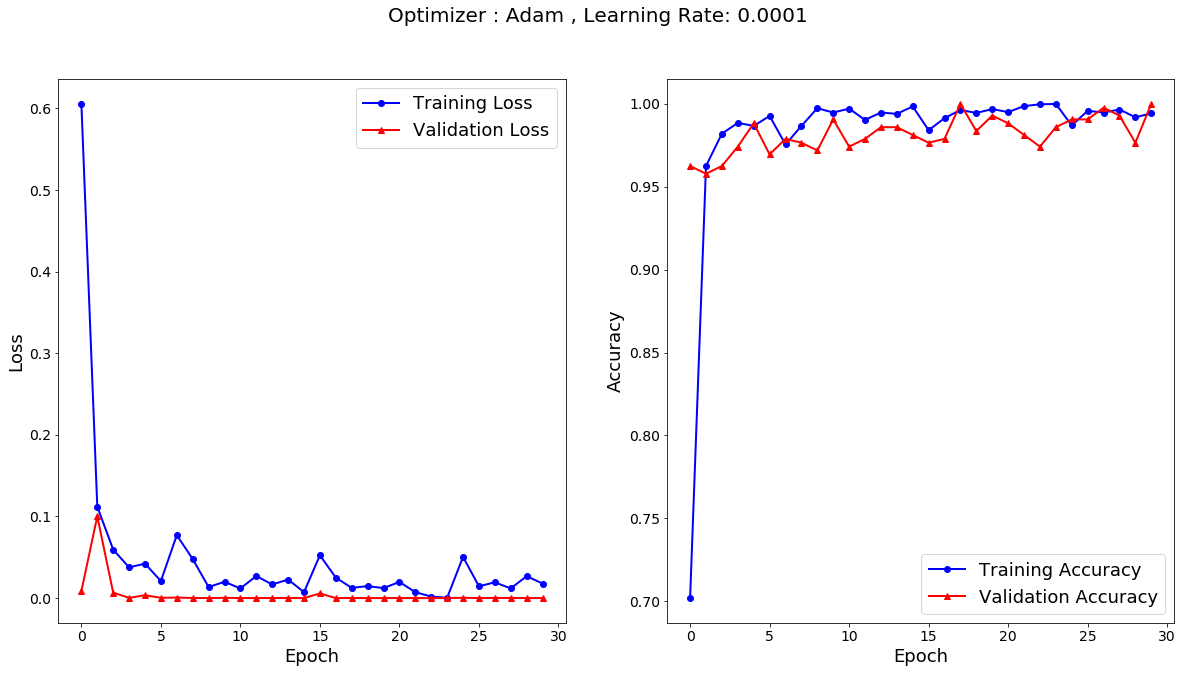

In [13]:
# Initializing the subplot 
plt.subplots(1,2,figsize=(20,10))

# Plotting the model's training and validation loss progression for every completed epoch 
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='^', color='red')

# Formatting axes and titles
plt.suptitle('Optimizer : Adam , Learning Rate: 0.0001', fontsize=20)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Formatting legend
plt.legend(loc='upper right', fontsize=18)

# Plotting the training and validation accuracy changes for every epoch 
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='^', color='red')

# Formatting axes and titles
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Formatting legend
plt.legend(loc='lower right', fontsize=18)

# Display the plots
plt.show()

## Model Evaluation 

In order to evaluate the `bestmodel`'s performance we will need to load in the `best_weights_vgg16.h5` saved by `ModelCheckpoint()`. 

In [14]:
# Saving the CNN architecture as a JSON
modelarch_json = model.to_json()
with open("rps_VGG16.json","w") as json_file:
    json_file.write(modelarch_json)
    
# Initialize the 'bestmodel' using the weights saved with the ModelCheckpoint callback
bestmodel = model_from_json(modelarch_json)

# Loading the weights that resulted in the best validation accuracy during training 
bestmodel.load_weights("best_weights_vgg16.h5")

# Compile the bestmodel
bestmodel.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

The `bestmodel` that resulted from training will be evaluated via classification reports and confusion matrices normalized by the number of images for the given class. 

In [15]:
# Creating axis labels for future sns.heatmaps 

# Getting the class names
categories = list(train_generator.class_indices.keys())

# Preficing classes with 'Predicted ' 
predicted_labels = list('Predicted '  + category for category in categories)

# Preficing classes with 'True '
true_labels = list('True ' + category for category in categories)

# Creating labels(indices) for model evaluation metrics 
eval_metrics = list(bestmodel.metrics_names)

**NOTE:** Unable to create a classification report or confusion matrix for train data as train_generator(shuffle=True) does not save the true classes 

In [16]:
# Re-evaluating the best model's performance on the training data
train_eval = bestmodel.evaluate_generator(train_generator, steps=train_stepsize)

# Saving the results to a dataframe
df_train_eval = pd.DataFrame(list(train_eval), index=eval_metrics, columns=['Train'])

# Display the results
print(df_train_eval)

             Train
loss      0.000019
accuracy  0.998699


Thus, `bestmodel` achieved 99.9% accuracy and < 0.0001 categorical crossentropy loss on the train dataset. 

-----

### Evaluating `bestmodel` Performance on the Validation Dataset

First, we will acquire the model's predictions and saving to variable `valid_predictions`. 

In [18]:
# Getting bestmodel's predictions (as probabilities) on the validation images 
validation_probas = bestmodel.predict_generator(validation_generator, steps=valid_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
valid_predictions = validation_probas.argmax(axis=1)

# Sanity check 
valid_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Next, acquiring the images' true labels and saving to variable `valid_true`. 

In [19]:
# Getting the true class labels for the validation data
valid_true = validation_generator.classes

# Sanity check 
valid_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Finally, we will compare `valid_predictions` with `valid_true` to acquire model accuracy, precision, recall, f1-scores and a confusion matrix. 

In [20]:
# Evaluating bestmodel's performance on the validation data 
valid_eval = bestmodel.evaluate_generator(validation_generator, steps=valid_stepsize)

# Saving the results to a dataframe
df_valid_eval = pd.DataFrame(list(valid_eval), index=eval_metrics, columns=['Validation'])

# Display the results 
print(df_valid_eval)

          Validation
loss        0.000251
accuracy    0.995316


Thus, `bestmodel` achieved 99.5% accuracy and 0.0003 categorical crossentropy loss on the validation dataset.

In [21]:
# Displaying the classification report for the validation set
print('Validation Classification Report\n \n', classification_report(valid_true, valid_predictions, target_names=categories))

Validation Classification Report
 
               precision    recall  f1-score   support

       paper       1.00      0.99      0.99       141
        rock       0.99      1.00      1.00       142
    scissors       0.99      1.00      1.00       144

    accuracy                           1.00       427
   macro avg       1.00      1.00      1.00       427
weighted avg       1.00      1.00      1.00       427



`bestmodel` also had high precision, recall and f1-scores, which ranged from 99 - 100 %. 

In [22]:
# Creating a non-normalized confusion matrix for the validation set
valid_matrix = pd.DataFrame(confusion_matrix(valid_true, valid_predictions), columns=predicted_labels, index=true_labels)

# Display the matrix
valid_matrix

,Predicted paper,Predicted rock,Predicted scissors
True paper,139,1,1
True rock,0,142,0
True scissors,0,0,144


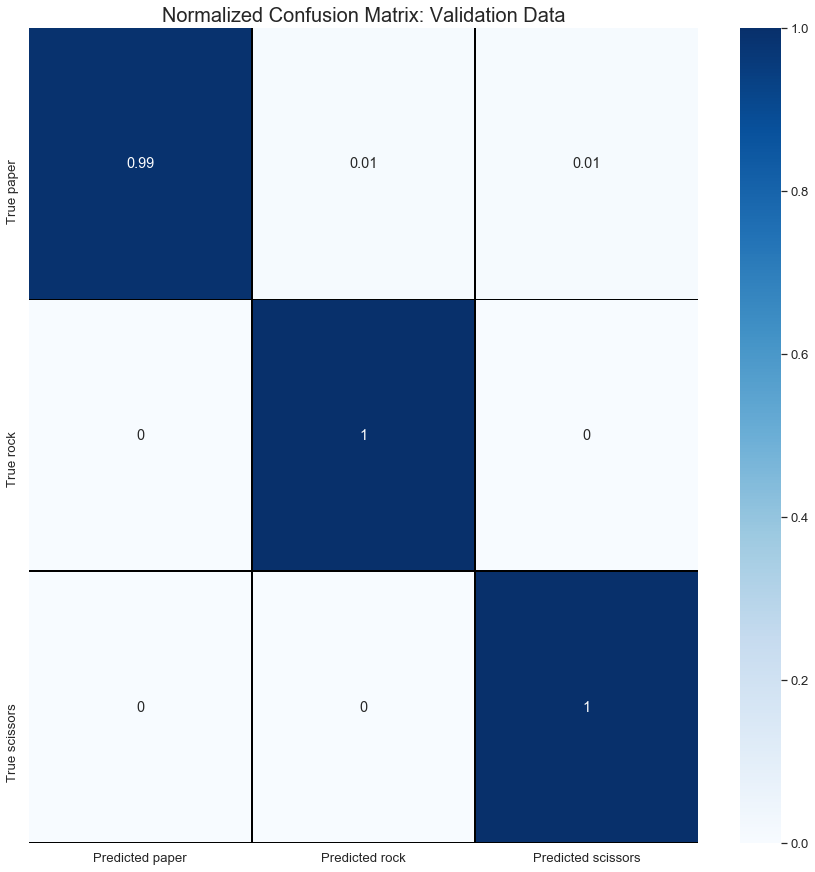

In [24]:
# Plotting the normalized confusion matrix (proportion of predictions by class) as a heatmap

# Increasing fontsize
sns.set(font_scale=1.2)

# Creating the plot
plt.figure(figsize=(15,15))
sns.heatmap(round(valid_matrix/valid_matrix.sum(axis=1)[:,np.newaxis],2), cmap='Blues', annot=True, linewidths=.5, linecolor='black')

# Formatting the title 
plt.title('Normalized Confusion Matrix: Validation Data', fontsize=20)

# Display the normalized confusion matrix
plt.show()

Based on the non-normalized and normalized confusion matrices, `bestmodel` proved successful at predicting the classes of the validation set. 

-----

### Evaluating `bestmodel` Performance on the Test Dataset

Similar as above, we will first acquire the model's predictions and saving to variable `test_predictions`. 

In [25]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas = bestmodel.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions = test_probas.argmax(axis=1)

# Sanity check 
test_predictions

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Next, saving the true classes of the test images to the variable `test_true`. 

In [26]:
# Getting the true class labels for the test set
test_true = test_generator.classes

# Sanity check 
test_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Finally, we will compare `test_predictions` with `test_true` to acquire model accuracy, precision, recall, f1-scores and confusion matrices to evalute model performance on the test set. 

In [27]:
# Evaluating the best model's performance on the test data 
test_eval = bestmodel.evaluate_generator(test_generator, steps=test_stepsize)

# Saving the results to a dataframe 
df_test_eval = pd.DataFrame(list(test_eval), index=eval_metrics, columns=['Test'])

# Display the results
print(df_test_eval)

              Test
loss      0.000066
accuracy  0.992583


`bestmodel` achieved 99.3% accuracy and < 0.0001 categorical crossentropy loss on the test set.

In [20]:
# Displaying the classification report for the test set
print('Test Classification Report\n \n', classification_report(test_true, test_predictions, target_names=categories))

Test Classification Report
 
               precision    recall  f1-score   support

       paper       1.00      0.96      0.98       195
        rock       0.99      1.00      0.99       196
    scissors       0.98      1.00      0.99       199

    accuracy                           0.99       590
   macro avg       0.99      0.99      0.99       590
weighted avg       0.99      0.99      0.99       590



`bestmodel` also achieved great precision, recall and f1-scores, which ranged from 96 - 100 %. 

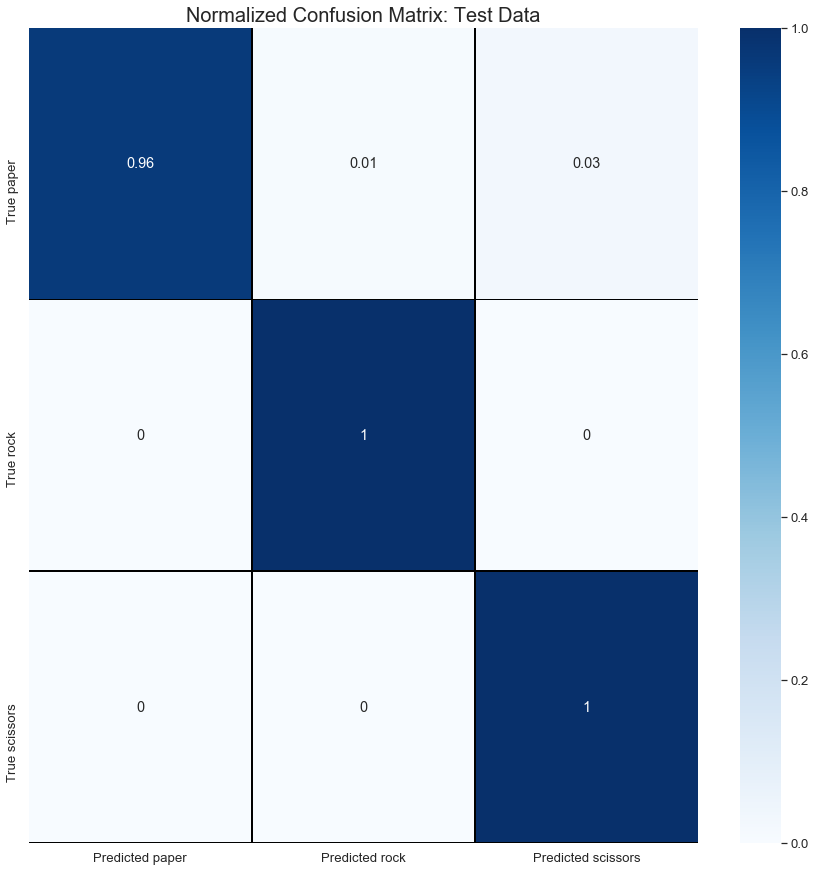

In [21]:
# Non-normalized confusion matrix for the test data
test_matrix = pd.DataFrame(confusion_matrix(test_true, test_predictions), columns=predicted_labels, index=true_labels)

# Plotting a normalized confusion matrix for the test data as a heatmap 
sns.set(font_scale=1.2)
plt.figure(figsize=(15,15))
sns.heatmap(round(test_matrix/test_matrix.sum(axis=1)[:,np.newaxis],2), cmap='Blues', annot=True, linewidths=.5, linecolor='black')
plt.title('Normalized Confusion Matrix: Test Data', fontsize=20)
plt.show()

Based on the non-normalized and normalized confusion matrices, `bestmodel` proved successful at predicting the classes of images it had never seen before (i.e., test set images). 

However, the test images were very similar to the images that the VGG16 CNN was trained on, which may account for the high accuracy, precision, recall and f1 scores seen across the validation and test sets. 

-----

Keeping in mind that the final goal is to classify rock, paper or scissors from images taken in real-time, the model trained in this notebook will undergo additional evaluation of: 

**Predicting on images taken from live webcam in the subsequent notebook** `real-time_test.ipynb`. 